## The project aims to predict building abandonment (“blight”) based on a number of public datasets, including criminal incidents, permit violations, and more. 

#### This project grew out of a roundtable discussion with Socrata and city analytics leaders in Detroit, Kansas City, New Orleans, Boston, and more.

#### These cities shared a common interest in being proactive about identifying buildings at risk for abandonment and taking steps to prevent the harms that arise as a result. 

### Method of identification of blighted virtual building

All data files consist of incident data: each record is an incident which occurred at a particular time and place.

In particlular we ave four datasets available: 

1. detroit-blight-violations.csv : Each record is a blight violation incident.
2. detroit-demolition-permits.tsv: Each record represents a permit for a demolition.
3. detroit-311.csv: Each record represents a 311 call, typically a complaint
4. detroit-crime.csv: Each record represents a criminial incident.
For each incident type, the location is included as a latitude, longitude pair and various timestamps are included, typically in the format mm/dd/yyyy hh:mm:ss PM, for example 03/11/2015 04:23:11 PM.

The files are made available directly as Coursera assets, and forked in this reposotory.

The location of each incident is provided as geo-coordinates: a (latitude, longitude) pair. The project involves classifying the blight risk of specific buildings, so a first step is to parse the geo coordinate data and use these coordinates to try to cluster all incidents that occurred, ideally, at the same address.


#### Creation of "virtual building"
We will create "virtual building" clustering te demolition coordinates by the aversine distance (a geodetic measurement of te geographic distance), and then tracking an alpha hull (ahull with flat edges) using the outer poit of each cluster created by the clustering algorithm (based on haversine distance).

This will allow us to get a valid, specific "virtual building", much more effective then it could be possible with other methods (i.e. draw outer circle lowering the coordinates precision, or drawing box/rectangles starting from a coordinates point).

This is because those other methods are "blinded" : meaning this, that the "virtual building" is expanded also in some direction not related to the greater density of blight coordinates existing (from demolition permits dataset).

The method here used, takes in account for each cluster a higher geographic density of blighted coordinates, therefore performing as a powerful predictor of blighting.

In [29]:

require(compiler)
enableJIT(3)

set.seed(329)
options(digits=11)
#options(warn=1)
options(warn=-1)
Sys.setlocale("LC_TIME", "English")

options(jupyter.plot_mimetypes = 'image/png')
library(stringr)
library(ggmap)
library("RJSONIO")
library("magrittr")
library(png)
library(gridExtra)
library(dbscan)
library(png)
library(grid)
library(ggplot2)
library(ggmap)
library(igraph)
library(leaderCluster)
library(alphahull)
library(sp)
library(plyr) # for reordering lat lon plygon
library(RColorBrewer)
library(caret)
library(e1071)
library(arm)

runThis <- F

[1] 3

[1] "English_United States.1252"

                                                                       
##### Test to apply analysis on live data                                     

Once defined the analysis, is it possible to extract the data on periodic basis and get a temporal trend (code below).

In this analysis will be used only the historical datasets already available from Coursera.

In [ ]:
# library(jsonlite)
# rl <- "https://data.detroitmi.gov/resource/uzpg-2pfj.json"
# detdemlive <- fromJSON(txt=url)
# # url at socrata including token from personal Application account
# urldetdem <- "https://data.detroitmi.gov/resource/uzpg-2pfj.json?$$app_token=heregoeasmytoken"
# detdemlive <- fromJSON(txt=urldetdem)
# read url and convert to data.frame
# detdemlive$location <- NULL

### Defining functions.

##### [FastForward to create building section](#createbuilding)

#### _Recompile ahull function (ashape package)  - fixed -_

In [8]:
ahull <- function (x, y = NULL, alpha) 
{
        ashape.obj <- ashape(x, y, alpha)
        compl <- complement(ashape.obj$delvor.obj, alpha = alpha)
        pm.x <- (compl[, "x1"] + compl[, "x2"]) * 0.5
        pm.y <- (compl[, "y1"] + compl[, "y2"]) * 0.5
        dm <- sqrt((compl[, "x1"] - compl[, "x2"])^2 + (compl[, "y1"] - 
                                                                compl[, "y2"])^2) * 0.5
        ashape.edges <- matrix(ashape.obj$edges[, c("ind1", "ind2")], 
                               ncol = 2, byrow = FALSE)
        noforget <- ashape.obj$alpha.extremes
        ind2 <- integer()
        j <- 0
        case <- 0  # Gianfranco Campana bugfixed
        nshape <- length(ashape.edges) * 0.5
        arcs <- matrix(0, nrow = nshape, ncol = 6)
        indp <- matrix(0, nrow = nshape, ncol = 2)
        cutp <- ashape.obj$x
        if (nshape > 0) {
                for (i in 1:nshape) {
                        ind <- which(ashape.edges[i, 1] == compl[, "ind1"] & 
                                             ashape.edges[i, 2] == compl[, "ind2"])
                        if (length(ind) > 0) {
                                if (!((1 <= sum((compl[ind, "ind"] == 1))) & 
                                      (sum((compl[ind, "ind"] == 1)) < length(ind)))) {
                                        which <- which(compl[ind, "r"] == min(compl[ind[compl[ind, 
                                                                                              "r"] > 0], "r"]))
                                        j <- j + 1
                                        arcs[j, ] <- c(compl[ind[which], 1], compl[ind[which], 
                                                                                   2], compl[ind[which], 3], compl[ind[which], 
                                                                                                                   "v.x"], 
                                                       compl[ind[which], "v.y"], compl[ind[which],
                                                                                       "theta"])
                                        vaux <- compl[ind[which], c("x1", "y1")] - 
                                                cbind(pm.x, pm.y)[ind[which], ]
                                        theta.aux <- rotation(compl[ind[which], c("v.x", 
                                                                                  "v.y")], compl[ind[which], "theta"])
                                        a2 <- sum(vaux * theta.aux)
                                        if (a2 > 0) {
                                                indp[j, ] <- compl[ind[which], c("ind1", 
                                                                                 "ind2")]
                                        }
                                        else {
                                                indp[j, ] <- compl[ind[which], c("ind2", 
                                                                                 "ind1")]
                                        }
                                }
                                ind2 <- c(ind2, ind)
                        }
                }
        }
        arcs.old <- arcs[arcs[, 3] > 0, ]
        colnames(arcs.old) <- c("c1", "c2", "r", "v.x", "v.y", "theta")
        arcs <- arcs.old
        indp <- indp[indp[, 1] != 0 & indp[, 2] != 0, ]
        n.arc <- dim(arcs)[1]
        watch <- 1
        j <- 1
        if (n.arc > 0) {
                while (watch <= n.arc) {
                        ind.arc <- 1:n.arc
                        while (j <= n.arc) {
                                if (j != watch) {
                                        intersection <- inter(arcs[watch, 1], arcs[watch, 
                                                                                   2], arcs[watch, 3], arcs[j, 1], arcs[j, 2], 
                                                              arcs[j, 3])
                                        if (intersection$n.cut == 2) {
                                                v.arc <- c(arcs[watch, "v.x"], arcs[watch, 
                                                                                    "v.y"])
                                                if (v.arc[2] >= 0) {
                                                        ang.OX <- acos(v.arc[1])
                                                }
                                                else {
                                                        ang.OX <- 2 * pi - acos(v.arc[1])
                                                }
                                                v.arc.rot <- rotation(v.arc, ang.OX)
                                                v.int <- intersection$v1
                                                v.int.rot <- rotation(v.int, ang.OX)
                                                if (v.int.rot[2] >= 0) {
                                                        ang.v.int.rot.OX <- acos(v.int.rot[1])
                                                        angles <- c(-arcs[watch, "theta"], arcs[watch, 
                                                                                                "theta"], ang.v.int.rot.OX - 
                                                                    intersection$theta1, 
                                                                    ang.v.int.rot.OX + intersection$theta1)
                                                        names(angles) <- c("theta1", "theta2", 
                                                                           "beta1", "beta2")
                                                        order <- names(sort(angles))
                                                        theta1 <- ang.OX - arcs[watch, "theta"]
                                                        theta2 <- ang.OX + arcs[watch, "theta"]
                                                        beta1 <- ang.v.int.rot.OX + ang.OX - intersection$theta1
                                                        beta2 <- ang.v.int.rot.OX + ang.OX + intersection$theta1
                                                }
                                                else {
                                                        ang.v.int.rot.OX <- acos(v.int.rot[1])
                                                        angles <- c(-arcs[watch, "theta"], arcs[watch, 
                                                                                                "theta"], -ang.v.int.rot.OX - 
                                                                    intersection$theta1, 
                                                                    -ang.v.int.rot.OX + intersection$theta1)
                                                        names(angles) <- c("theta1", "theta2", 
                                                                           "beta1", "beta2")
                                                        order <- names(sort(angles))
                                                        theta1 <- ang.OX - arcs[watch, "theta"]
                                                        theta2 <- ang.OX + arcs[watch, "theta"]
                                                        beta1 <- -ang.v.int.rot.OX + ang.OX - intersection$theta1
                                                        beta2 <- -ang.v.int.rot.OX + ang.OX + intersection$theta1
                                                }
                                                if (sum(match(indp[watch, ], indp[j, ], nomatch = 0)) > 
                                                    0) {
                                                        coinc <- indp[j, sum(match(indp[watch, 
                                                                                        ], indp[j, ], nomatch = 0))]
                                                        if (indp[watch, 1] == indp[j, 2]) {
                                                                if (all(order == c("beta1", "beta2", 
                                                                                   "theta1", "theta2"))) {
                                                                        case <- 1
                                                                }
                                                                else if (all(order == c("theta1", "beta1", 
                                                                                        "beta2", "theta2"))) {
                                                                        case <- 2
                                                                }
                                                                else if (all(order == c("beta1", "theta1", 
                                                                                        "beta2", "theta2"))) {
                                                                        ang.control <- (angles["theta1"] - 
                                                                                                angles["beta1"])/2
                                                                        if (abs(ang.control) < 1e-05) {
                                                                                case <- 2
                                                                        }
                                                                        else {
                                                                                case <- 1
                                                                        }
                                                                }
                                                                if (case == 2) {
                                                                        ang.middle2 <- (angles["theta2"] - 
                                                                                                angles["beta2"])/2
                                                                        v.new2 <- rotation(c(1, 0), -arcs[watch, 
                                                                                                          "theta"] + 
                                                                                           ang.middle2 - ang.OX)
                                                                        cutp <- rbind(cutp, arcs[watch, 1:2] + 
                                                                                              arcs[watch, 3] * 
                                                                                      rotation(v.new2, ang.middle2))
                                                                        inn <- dim(cutp)[1]
                                                                        arcs[watch, 4:6] <- c(v.new2, ang.middle2)
                                                                        indp[watch, 1] <- inn
                                                                        pmaux <- (cutp[inn, ] + cutp[indp[j, 
                                                                                                          1], ]) * 0.5
                                                                        dmaux <- pmaux - cutp[indp[j, 1], ]
                                                                        ndmaux <- sqrt(sum(dmaux^2))
                                                                        vaux <- pmaux - arcs[j, 1:2]
                                                                        nvaux <- sqrt(sum(vaux^2))
                                                                        th <- atan(ndmaux/nvaux)
                                                                        arcs[j, 4:6] <- c(vaux/nvaux, th)
                                                                        indp[j, 2] <- inn
                                                                }
                                                        }
                                                        else if (indp[watch, 2] == indp[j, 1]) {
                                                                if (all(order == c("theta1", "theta2", 
                                                                                   "beta1", "beta2"))) {
                                                                        case <- 1
                                                                }
                                                                else if (all(order == c("theta1", "beta1", 
                                                                                        "beta2", "theta2"))) {
                                                                        case <- 2
                                                                }
                                                                else if (all(order == c("theta1", "beta1", 
                                                                                        "theta2", "beta2"))) {
                                                                        ang.control <- (angles["theta2"] - 
                                                                                                angles["beta2"])/2
                                                                        if (abs(ang.control) < 1e-05) {
                                                                                case <- 2
                                                                        }
                                                                        else {
                                                                                case <- 1
                                                                        }
                                                                }
                                                                if (case == 2) {
                                                                        ang.middle <- (angles["beta1"] - angles["theta1"])/2
                                                                        v.new <- rotation(c(1, 0), arcs[watch, 
                                                                                                        "theta"] - 
                                                                                          ang.middle - ang.OX)
                                                                        cutp <- rbind(cutp, arcs[watch, 1:2] + 
                                                                                              arcs[watch, 3] * 
                                                                                      rotation(v.new, -ang.middle))
                                                                        inn <- dim(cutp)[1]
                                                                        arcs[watch, 4:6] <- c(v.new, ang.middle)
                                                                        indp[watch, 2] <- inn
                                                                        pmaux <- (cutp[inn, ] + cutp[indp[j, 
                                                                                                          2], ]) * 0.5
                                                                        dmaux <- pmaux - cutp[indp[j, 2], ]
                                                                        ndmaux <- sqrt(sum(dmaux^2))
                                                                        vaux <- pmaux - arcs[j, 1:2]
                                                                        nvaux <- sqrt(sum(vaux^2))
                                                                        th <- atan(ndmaux/nvaux)
                                                                        arcs[j, 4:6] <- c(vaux/nvaux, th)
                                                                        indp[j, 1] <- inn
                                                                }
                                                        }
                                                }
                                                else if (all(order == c("theta1", "beta1", 
                                                                        "beta2", "theta2"))) {
                                                        v.arcj <- c(arcs[j, "v.x"], arcs[j, "v.y"])
                                                        if (v.arcj[2] >= 0) {
                                                                ang.OXj <- acos(v.arcj[1])
                                                        }
                                                        else {
                                                                ang.OXj <- 2 * pi - acos(v.arcj[1])
                                                        }
                                                        v.arc.rotj <- rotation(v.arcj, ang.OXj)
                                                        v.intj <- intersection$v2
                                                        v.int.rotj <- rotation(v.intj, ang.OXj)
                                                        if (v.int.rotj[2] >= 0) {
                                                                ang.v.int.rot.OXj <- acos(v.int.rotj[1])
                                                                anglesj <- c(-arcs[j, "theta"], arcs[j, 
                                                                                                     "theta"], 
                                                                             ang.v.int.rot.OXj - 
                                                                             intersection$theta2, 
                                                                             ang.v.int.rot.OXj + intersection$theta2)
                                                                names(anglesj) <- c("theta1", "theta2", 
                                                                                    "beta1", "beta2")
                                                                orderj <- names(sort(anglesj))
                                                                theta1j <- ang.OXj - arcs[j, "theta"]
                                                                theta2j <- ang.OXj + arcs[j, "theta"]
                                                                beta1j <- ang.v.int.rot.OXj + ang.OXj - 
                                                                        intersection$theta2
                                                                beta2j <- ang.v.int.rot.OXj + ang.OXj + 
                                                                        intersection$theta2
                                                        }
                                                        else {
                                                                ang.v.int.rot.OXj <- acos(v.int.rotj[1])
                                                                anglesj <- c(-arcs[j, "theta"], arcs[j, 
                                                                                                     "theta"], 
                                                                             -ang.v.int.rot.OXj - 
                                                                             intersection$theta2, 
                                                                             -ang.v.int.rot.OXj + intersection$theta2)
                                                                names(anglesj) <- c("theta1", "theta2", 
                                                                                    "beta1", "beta2")
                                                                orderj <- names(sort(anglesj))
                                                                theta1j <- ang.OXj - arcs[j, "theta"]
                                                                theta2j <- ang.OXj + arcs[j, "theta"]
                                                                beta1j <- -ang.v.int.rot.OXj + ang.OXj - 
                                                                        intersection$theta2
                                                                beta2j <- -ang.v.int.rot.OXj + ang.OXj + 
                                                                        intersection$theta2
                                                        }
                                                        if (all(orderj == c("theta1", "beta1", 
                                                                            "beta2", "theta2"))) {
                                                                ang.middle <- (angles["beta1"] - angles["theta1"])/2
                                                                v.new <- rotation(c(1, 0), arcs[watch, 
                                                                                                "theta"] - 
                                                                                  ang.middle - ang.OX)
                                                                ang.middle2 <- (angles["theta2"] - angles["beta2"])/2
                                                                v.new2 <- rotation(c(1, 0), -arcs[watch, 
                                                                                                  "theta"] + 
                                                                                   ang.middle2 - ang.OX)
                                                                arcs <- rbind(arcs, c(arcs[watch, 1], 
                                                                                      arcs[watch, 2], arcs[watch, 3], v.new2[1], 
                                                                                      v.new2[2], ang.middle2))
                                                                arcs[watch, ] <- c(arcs[watch, 1], arcs[watch, 
                                                                                                        2], 
                                                                                   arcs[watch, 3], 
                                                                                   v.new[1], 
                                                                                   v.new[2], 
                                                                                   ang.middle)
                                                                n.arc <- n.arc + 1
                                                                np1 <- arcs[watch, 1:2] + arcs[watch, 
                                                                                               3] * rotation(v.new, -ang.middle)
                                                                np2 <- arcs[watch, 1:2] + arcs[watch, 
                                                                                               3] * rotation(v.new2, ang.middle2)
                                                                indold <- indp[watch, 2]
                                                                inn1 <- dim(cutp)[1] + 1
                                                                inn2 <- dim(cutp)[1] + 2
                                                                indp[watch, 2] <- inn1
                                                                indp <- rbind(indp, c(inn2, indold))
                                                                cutp <- rbind(cutp, np1)
                                                                cutp <- rbind(cutp, np2)
                                                                indold <- indp[j, 1]
                                                                indp[j, 1] <- inn1
                                                                indp <- rbind(indp, c(indold, inn2))
                                                                pmaux <- (cutp[inn1, ] + cutp[indp[j, 
                                                                                                   2], ]) * 0.5
                                                                dmaux <- pmaux - cutp[indp[j, 2], ]
                                                                ndmaux <- sqrt(sum(dmaux^2))
                                                                vaux <- pmaux - arcs[j, 1:2]
                                                                nvaux <- sqrt(sum(vaux^2))
                                                                th <- atan(ndmaux/nvaux)
                                                                arcs[j, 4:6] <- c(vaux/nvaux, th)
                                                                pmaux <- (cutp[inn2, ] + cutp[indold, 
                                                                                              ]) * 0.5
                                                                dmaux <- pmaux - cutp[indold, ]
                                                                ndmaux <- sqrt(sum(dmaux^2))
                                                                vaux <- pmaux - arcs[j, 1:2]
                                                                nvaux <- sqrt(sum(vaux^2))
                                                                th <- atan(ndmaux/nvaux)
                                                                arcs <- rbind(arcs, c(arcs[j, 1:3], vaux/nvaux, 
                                                                                      th))
                                                                n.arc <- n.arc + 1
                                                        }
                                                }
                                        }
                                        case <- 0
                                }
                                j <- j + 1
                        }
                        watch <- watch + 1
                        j <- 1
                }
                ord.old <- 1:dim(indp)[1]
                ord.new <- numeric()
                while (length(ord.new) < length(ord.old)) {
                        if (length(ord.new) == 0) {
                                ord.new <- 1
                        }
                        else {
                                ord.new <- c(ord.new, ord.old[-ord.new][1])
                        }
                        coinc <- match(indp[ord.new[length(ord.new)], 2], 
                                       indp[-ord.new, 1])
                        while (!is.na(coinc)) {
                                ord.new <- c(ord.new, ord.old[-ord.new][coinc])
                                coinc <- match(indp[ord.new[length(ord.new)], 
                                                    2], indp[-ord.new, 1])
                        }
                }
                indp <- indp[ord.new, ]
                ahull.arcs <- cbind(arcs[ord.new, ], indp)
                colnames(ahull.arcs) <- c("c1", "c2", "r", "v.x", "v.y", 
                                          "theta", "end1", "end2")
                lengthah <- lengthahull(arcs)
                addp <- noforget[is.na(match(noforget, indp))]
                num <- length(addp)
                if (num > 0) {
                        mat.noforget <- cbind(matrix(ashape.obj$x[addp, 1:2], 
                                                     ncol = 2, byrow = FALSE), rep(0, num), rep(0, 
                                                                                                num), 
                                              rep(0, num), rep(0, num), addp, addp)
                        ahull.arcs <- rbind(ahull.arcs, mat.noforget)
                }
        }
        else {
                num <- length(noforget)
                ahull.arcs <- cbind(ashape.obj$x[noforget, ], rep(0, 
                                                                  num), rep(0, num), rep(0, num), rep(0, num), noforget, 
                                    noforget)
                colnames(ahull.arcs) <- c("c1", "c2", "r", "v.x", "v.y", 
                                          "theta", "end1", "end2")
                lengthah <- 0
        }
        ahull.obj <- list(arcs = ahull.arcs, xahull = cutp, length = lengthah, 
                          complement = compl, alpha = alpha, ashape.obj = ashape.obj)
        class(ahull.obj) <- "ahull"
        invisible(ahull.obj)
}
         

#### _Define a function that will process geocode from Google     _

In [9]:
getGeoDetails <- function(address){   
  #use the gecode function to query google servers
  geo_reply = geocode(address, output='all', messaging=TRUE, override_limit=TRUE)
  #now extract the bits that we need from the returned list
  answer <- data.frame(lat=NA, long=NA, accuracy=NA, formatted_address=NA, address_type=NA, status=NA)
  answer$status <- geo_reply$status
  
  #if we are over the query limit - want to pause for an hour
  while(geo_reply$status == "OVER_QUERY_LIMIT"){
    print("OVER QUERY LIMIT - Pausing for 1 hour at:") 
    time <- Sys.time()
    print(as.character(time))
    Sys.sleep(60*60)
    geo_reply = geocode(address, output='all', messaging=TRUE, override_limit=TRUE)
    answer$status <- geo_reply$status
  }
  
  #return Na's if we didn't get a match:
  if (geo_reply$status != "OK"){
    return(answer)
  }   
  #else, extract what we need from the Google server reply into a dataframe:
  answer$lat  <- geo_reply$results[[1]]$geometry$location$lat
  answer$long <- geo_reply$results[[1]]$geometry$location$lng   
  if (length(geo_reply$results[[1]]$types) > 0){
    answer$accuracy <- geo_reply$results[[1]]$types[[1]]
  }
  answer$address_type      <- paste(geo_reply$results[[1]]$types, collapse=',')
  answer$formatted_address <- geo_reply$results[[1]]$formatted_address
  
  return(answer)
}


#### _Define the multiplot function (Plot multiple plots in a single pane)_

In [10]:
#'Plot multiple plots in a single pane
#'
#'ggplot objects can be passed in ..., or to plotlist (as a list of ggplot objects)
#' @import grid ggplot2
#' @export
#' 
#' @param ... Two or more ggplot2 objects
#' @param  plotlist (optional) a list of ggplot2 objects
#' @param  cols Number of columns in layout
#' @param  layout A matrix specifying the layout. If present, 'cols' is ignored. See Details
#' @param  title Optional title as a character string
#' @param  widths a vector of relative column widths eg. c(3,2)
#' @param  heights a vector of relative column heights eg. c(3,2)
#' @param  titlefont The font of the title
#' @param  titleface The font face (1 = normal, 2 = bold, 3 = italic, 4 = bold italic)
#' @param  titlesize The size of the title font
#' 
#' @details If plotting three plots and the layout is something like
#'   matrix(c(1,2,3,3), nrow=2, byrow=TRUE), then plot 1 will go in the upper
#'   left, 2 will go in the upper right, and 3 will go all the way across the
#'   bottom.  To save, you must use the desired device (eg \code{png()}), or
#'   save from the RStudio Viewer.
#' 
#' Borrowed and modified from http://www.cookbook-r.com/Graphs/Multiple_graphs_on_one_page_(ggplot2)/
#' 
#' @return NULL (invisibly)
#' @examples \dontrun{
#' library("ggplot2")
#' plot1 <- ggplot(iris, aes(x = Species, y = Sepal.Length)) + 
#'    geom_bar(stat = "identity")
#' plot2 <- ggplot(mtcars, aes(x = mpg, y = disp)) + 
#'    geom_smooth()
#' multiplot(plot1, plot2, cols = 2, widths = c(3,2), title = "My two unrelated plots")
#' multiplot(plot1, plot2, cols = 1, heights = c(10,2), title = "My two unrelated plots")
#' myplots <- list(plot1, plot2, plot1)
#' multiplot(plotlist = myplots, layout =matrix(c(1,2,3,3), nrow=2), 
#'      heights = c(1,3), widths = c(3,4), title = "My three unrelated plots")
#' ## Adjusting fonts
#' library(extrafont)
#' loadfonts()
#' multiplot(plotlist = myplots, layout =matrix(c(1,2,3,3), nrow=2),
#'           heights = c(1,3), widths = c(3,4), title = "My three unrelated plots", 
#'           titlefont = "Wingdings", titleface = 4, titlesize = 20)
#'}
multiplot <- function(..., plotlist=NULL, cols=1, layout=NULL, widths=NULL, heights=NULL, 
                      title=NULL, titlefont = "", titleface = 1, titlesize = 16) {
        
        # Make a list from the ... arguments and plotlist
        plots <- c(list(...), plotlist)
        
        numPlots = length(plots)
        
        # If layout is NULL, then use 'cols' to determine layout
        if (is.null(layout)) {
                # Make the panel
                # ncol: Number of columns of plots
                # nrow: Number of rows needed, calculated from # of cols
                layout <- matrix(seq(1, cols * ceiling(numPlots/cols)),
                                 ncol = cols, nrow = ceiling(numPlots/cols))
        }
        
        if (!is.null(title)) { # Add a narrow row at the top for the title
                layout <- rbind(rep(0,ncol(layout)),layout)
                if (is.null(heights)) {
                        plotrows <- nrow(layout)-1
                        rowheights <- c(0.1, rep(1,plotrows)/plotrows)
                } else {
                        rowheights <- c(0.1, heights/sum(heights))
                }
        } else {
                if (is.null(heights)) {
                        rowheights <- rep(1,nrow(layout))  
                } else {
                        rowheights <- heights
                }
        }
        
        if (is.null(widths)) {
                colwidths <- rep(1, cols)
        } else {
                colwidths <- widths
        }
        
        if (numPlots==1) {
                
                return(plots[[1]] + labs(title=title))
                
        } else {
                # Set up the page
                grid.newpage()
                pushViewport(viewport(layout = grid.layout(nrow(layout), ncol(layout), 
                                                           widths=colwidths, 
                                                           heights=rowheights)))
                
                # Make each plot, in the correct location
                for (i in 1:numPlots) {
                        # Get the i,j matrix positions of the regions that contain this subplot
                        matchidx <- as.data.frame(which(layout == i, arr.ind = TRUE))
                        
                        print(plots[[i]], vp = viewport(layout.pos.row = matchidx$row,
                                                        layout.pos.col = matchidx$col))
                }
                
                if (!is.null(title)) {
                        grid.text(title, vp = viewport(layout.pos.row = 1
                                                       , layout.pos.col = 1:ncol(layout)), 
                                  gp = gpar(fontfamily = titlefont, fontface = titleface, 
                                            fontsize = titlesize))
                }
                
        }
        return(invisible(NULL))
}

#### _Define a function to create style string from Gmap_

In [11]:
create_style_string <- function(style_list){
  style_string <- ""
  for(i in 1:length(style_list)){
    if("featureType" %in% names(style_list[[i]])){
      style_string <- paste0(style_string, "feature:", 
                             style_list[[i]]$featureType, "|")      
    }
    elements <- style_list[[i]]$stylers
    a <- lapply(elements, function(x)paste0(names(x), ":", x)) %>%
      unlist() %>%
      paste0(collapse="|")
    style_string <- paste0(style_string, a)
    if(i < length(style_list)){
      style_string <- paste0(style_string, "&style=")       
    }
  }  
  # google wants 0xff0000 not #ff0000
  style_string <- gsub("#", "0x", style_string)
  return(style_string)
  
}

#### _Define a function to plot and save demolition data against Point of Interest_

In [12]:
savemappoi <- function(poilist, dataframe) {
        lcplots <- list()
        for (currentpoi in poilist) {
                style <- paste0('[
                                {
                                "stylers": [
                                { "saturation": -100 },
                                { "lightness": 40 }
                                ]
                                },{
                                "featureType": "poi.', currentpoi, '",
                                "elementType": "geometry.fill",
                                "stylers": [
                                { "color": "#ff0000" },
                                { "gamma": 0.5 }
                                ]
                                },{
                                "featureType": "water",
                                "elementType": "geometry.fill",
                                "stylers": [
                                { "color": "#0000ff" }
                                ]
                                }
                                ]')
                style_list <- fromJSON(style, asText=TRUE)
                map_style  <- create_style_string(style_list)
                p <- ggmap(get_googlemap("42.330358, -83.086847", zoom=11, style=map_style, alpha=.5), extent="device") +
                        theme_bw() +
                        theme(
                                plot.background = element_blank()
                                ,panel.grid.major = element_blank()
                                ,panel.grid.minor = element_blank()
                                ,panel.border = element_blank()
                                ,legend.position = "none") +
                        # geom_point(alpha = .5, aes(
                        #         scale_fill = "white",
                        #         size = 1,
                        #         stroke = 1), shape = 21, fill = "white", lc_centroids)  +
                        # geom_point(data=lc_centroids)  +
                        # geom_label(data=lc_centroids, aes(x = lon, y = lat, label = as.character(cluster_id)))  +
                        stat_bin2d(
                                aes(x = lon, y = lat, colour = as.factor(cluster_id), fill = as.factor(cluster_id), drop = T),
                                size = .5, bins = 52, alpha = 0.3,
                                data = dataframe
                        ) +
                        # geom_line(data=coords, aes(x=lon, y=lat)) +
                        ggtitle(paste0(toupper(currentpoi))) + 
                        theme(plot.margin=unit(c(5,5,5.5,5.2),"points"))
                
                # print(p)
                # ggsave(p, filename=paste0("./blight/data/map_", currentpoi, "_zoom11.png"))
                lcplots[[paste0("map_", currentpoi)]] <- p
        }
        
        multiplot(plotlist = lcplots, cols=2, title = "Demolition Permits by Point of Interest (in red)\n 
clustered on lat/lon (haversine)", titlesize = 14, titleface = 3)
        dev.copy2pdf(file = "./blight/data/demolition_by_poi_haversine_latlon.pdf", width = 28, height = 28)
        # dev.copy(png, file = "./blight/data/demolition_by_poi_haversine_latlon.png", width = 28, height = 28)
        }

#### _Define a function to plot and save the alpha shape polygon of the clusters:   these are the "virtual buildings"_                           

In [13]:
savemapashape <- function(dflist) {
    style <- paste0('[
                    {
                    "stylers": [
                    { "saturation": -100 },
                    { "lightness": 40 }
                    ]
                    },{
                    "featureType": "water",
                    "elementType": "geometry.fill",
                    "stylers": [
                    { "color": "#0000ff" }
                    ]
                    }
                    ]')
    style_list <- fromJSON(style, asText=TRUE)
    map_style  <- create_style_string(style_list)
    
    p <- ggmap(get_googlemap("42.330358, -83.086847", zoom=11, style=map_style, alpha=.5), extent="device") + 
        theme_bw() +
        theme(
            plot.background = element_blank()
            ,panel.grid.major = element_blank()
            ,panel.grid.minor = element_blank()
            ,panel.border = element_blank()
            ,legend.position = "none") +
        ggtitle(paste0(("Alpha Shape of clusters with perimeter points"))) + 
        theme(plot.margin=unit(c(5,5,5.5,5.2),"points"))
    fillc <- colorRampPalette(brewer.pal(9, "Set1"))(length(ash))
    cb <- 1
    for (i in names(dflist)) {
        p <- p + 
            geom_polygon(data = ash[[i]], 
                         fill = fillc[cb], 
                         alpha = .4) +
            geom_point(data = ash[[i]], fill="red", alpha = .4, size = .2) 
        cb = cb +1
    }
    p1 <- p
    
    p <- ggmap(get_googlemap("42.330358, -83.086847", zoom=11, style=map_style, alpha=.5), extent="device") +
            theme_bw() +
            theme(
                    plot.background = element_blank()
                    ,panel.grid.major = element_blank()
                    ,panel.grid.minor = element_blank()
                    ,panel.border = element_blank()
                    ,legend.position = "none") +
            ggtitle(paste0(("Frequence of blights per building"))) +
            theme(plot.margin=unit(c(5,5,5.5,5.2),"points"))
    fillc <- colorRampPalette(brewer.pal(9, "Set1"))(length(ash))
            p <- p +
                geom_text(data=cluster_freq, size = 2, aes(x = lon, y = lat, label = as.character(freq), col = "red"))
    p2 <- p

    multiplot(p1, p2, cols=1, title = toupper("Buildings by Alpha Shape of clusters \n by haversine distance up to 300 meters"))
    dev.copy2pdf(file = "./blight/data/Buildings by Alpha Shape of clusters 300m.pdf", width = 22.275, height = 31.5)
}

#### _Define a function to assign to each location of each dataset a virtual building (as from our definition of virtual building) . Is it possible that a location belongs to more then one virtual building. _


In [14]:
assign_buildings <- function(coords, blist) {
    buildingslist <- c()
    for (b in names(blist)) {
        # IMPORTANT : inahull works only in the plane of coordinates of current hull
        # Check if coords are in plane, otherwise, skip.
        if (abs(coords[1]) >= min(abs(ahu[[b]][["ashape.obj"]][["edges"]][,3])) &
            abs(coords[1]) <= max(abs(ahu[[b]][["ashape.obj"]][["edges"]][,3])) &
            abs(coords[2]) >= min(abs(ahu[[b]][["ashape.obj"]][["edges"]][,4])) &
            abs(coords[2]) <= max(abs(ahu[[b]][["ashape.obj"]][["edges"]][,4])) ) {
            if (inahull(ahu[[b]], p = coords))  {
                buildingslist <- paste(buildingslist, b)
            }
        }
    }
    if (length(buildingslist) == 0) {
        buildingslist <- "!ahu"
    }
    return(buildingslist)
}

### Load datasets    

In [15]:
if (runThis == T) {
detviol  <- read.csv("./blight/data/detroit-blight-violations.csv", header = T, sep = ",", stringsAsFactors = F)   
det311   <- read.csv("./blight/data/detroit-311.csv", header = T, sep = ",", stringsAsFactors = F)     
detdem   <- read.csv("./blight/data/detroit-demolition-permits.tsv", header = T, sep="\t", stringsAsFactors = F)   
detcrime <- read.csv("./blight/data/detroit-crime.csv", header = T, sep=",", stringsAsFactors = F)     

names(detviol)  <- tolower(names(detviol))
names(det311)   <- tolower(names(det311))
names(detdem)   <- tolower(names(detdem))
names(detcrime) <- tolower(names(detcrime))
}


#### Normalize geolocations and extracting date


In [16]:

if (runThis == T) {

##### Normalize latitude and longitude from address in blight violation      
detviollatlon <- strsplit(gsub("[\\)\\( ]", "", str_extract(detviol$violationaddress, "\\(.*\\)")), ",")
detviol$lat <- sapply(detviollatlon, "[[", 1)
detviol$lon <- sapply(detviollatlon, "[[", 2)
length(which(is.na(detviollatlon)))
detviol$lat <- as.numeric(detviol$lat)
detviol$lon <- as.numeric(detviol$lon)




##### Normalize latitude and longitude from address in 311 calls             
det311latlon <- strsplit(gsub("[\\)\\( ]", "", str_extract(det311$location, "\\(.*\\)")), ",")
det311$lat <- sapply(det311latlon, "[[", 1)
names(det311)[13] <- "lon"
det311$lon <- sapply(det311latlon, "[[", 2)
length(which(is.na(det311latlon)))
det311$lat <- as.numeric(det311$lat)
det311$lon <- as.numeric(det311$lon)  




##### Extract latitude and longitude for demolition_permits.                                  
#######       NOTE: 803 rows have no site_location at all. # which(detdem$site_location == "" ) 
#######             14 rows have no lat/lon in site_location.                                    
#######             Once normalized the address, perform the geocode.                           

####### Normalize the site_location
detdem$site_location[which(detdem$site_location == "" )] <- 
    paste(detdem[which(detdem$site_location == "" ),]$site_address, ", Detroit, MI, United States")
which(detdem$site_location == "" ) # nomore

##### Extract lat/lon: if not present, then lat/lon is NA (817 rows).
detdemlatlon <- strsplit(gsub("[\\)\\( ]", "", str_extract(detdem$site_location, "\\(.*\\)")), ",")
length(which(is.na(detdemlatlon)))

geoind <- detdem[which(is.na(detdemlatlon)),]$site_location

# Add also address with wrong lat/lon
geoind <- append(geoind, gsub("\\n", " ", gsub("\\(.*\\)", "", detdem[which(detdem$lat > 43|
                                                                            detdem$lat < 42|
                                                                            detdem$lon < -84|
                                                                            detdem$lon > -81|
                                                                            is.na(detdem$lat)),]$site_location)))

# 14 obs have site_location 1= "", but without lat/lon. There is a /n in the string, to be removed. 

infile <- "detdem"

addresses <- geoind
length(addresses)

#initialise a dataframe to hold the results
geocoded <- data.frame()
# find out where to start in the address list (if the script was interrupted before):
startindex <- 1
#if a temp file exists - load it up and count the rows!
tempfilename <- paste0(infile, '_temp_geocoded.rds')
if (file.exists(tempfilename)){
  print("Found temp file - resuming from index:")
  geocoded <- readRDS(tempfilename)
  startindex <- nrow(geocoded)+1  # GC Editing to avoid duplicate
  print(startindex)
}

# Start the geocoding process - address by address. geocode() function takes care of query speed limit.
for (ii in seq(startindex, length(addresses))){
  print(paste("Working on index", ii, "of", length(addresses)))
  #query the google geocoder - this will pause here if we are over the limit.
  k = 1
  while (k < 6) {
  result = getGeoDetails(addresses[ii]) 
  if (!is.na(result$lat)) {
    result$index <- ii
    #append the answer to the results file.
    geocoded <- rbind(geocoded, result)
    #save temporary results as we are going along
    saveRDS(geocoded, tempfilename)
    k=6
  } else {
    k = k+1
    }
  }
}

if (any(is.na(geocoded))) {
  print(paste0("detdem - You looose...  ", as.character(length(which(is.na(geocoded$lat)))), 
               " addresses not geocoded, addresses index ", toString(which(is.na(geocoded$lat)))))
  } else {
    print("detdem - Perfect! You win !!!")
    }

geocoded[which(is.na(geocoded$lat)),]
addresses[which(is.na(geocoded$lat))]

# Normalizing site_location adding the missing lat/lon
detdem$site_location[which(is.na(detdemlatlon))] <- 
    paste0(detdem$site_location[which(is.na(detdemlatlon))], ", (", geocoded$lat, ", ", geocoded$long, ")")

# Normalizing also the wrong lat/lon
detdem$site_location[which(detdem$lat > 43|detdem$lat < 42|detdem$lon < -84|detdem$lon > -81|is.na(detdem$lat))] <- 
  paste0(gsub("\\n", " ", gsub("\\(.*\\)", "", detdem[which(detdem$lat > 43|
                                                            detdem$lat < 42|
                                                            detdem$lon < -84|
                                                            detdem$lon > -81|
                                                            is.na(detdem$lat)),]$site_location)), 
         ", (", geocoded$lat, ", ", geocoded$long, ")")

# Check that no more lat/lon is NA (0 rows).
length(which(is.na(strsplit(gsub("[\\)\\( ]", "", str_extract(detdem$site_location, "\\(.*\\)")), ","))))

# RE - Extract lat/lon: this time should be 0 NA.
detdemlatlon <- strsplit(gsub("[\\)\\( ]", "", str_extract(detdem$site_location, "\\(.*\\)")), ",")
length(which(is.na(detdemlatlon)))

detdem$lat <- sapply(detdemlatlon, "[[", 1)
detdem$lon <- sapply(detdemlatlon, "[[", 2)
detdem$lat <- as.numeric(detdem$lat)
detdem$lon <- as.numeric(detdem$lon)

# No more wrong values.
detdem[which(detdem$lat > 43|detdem$lat < 42|detdem$lon < -84|detdem$lon > -81|is.na(detdem$lat)),]$site_location

#Write it all to the output files
saveRDS(detdem, "detdem_geocoded.rds")
write.table(detdem, "detdem_geocoded.csv", sep=",", row.names=T)

# If detdem already normalized and saved
detdem <- readRDS("detdem_geocoded.rds")



#############################################################
#                                                           #
# Extract lat/lon fot detcrime.                             #
#     NOTE: detcrime has 59 obs without lat/lon.            #
#           and 373 lat lon wrong                           #
#############################################################
nrow(detcrime[which(is.na(as.numeric(detcrime$lat))),])

# summary(detdem$lat)
# summary(detviol$lat)
# summary(det311$lat)
# 
# summary(detdem$lon)
# summary(detviol$lon)
# summary(det311$lon)
# summary(detcrime$lat)

nrow(detcrime[which(detcrime$lat < 41.88 | detcrime$lat > 42.75 | detcrime$lon < -83.32 | detcrime$lon > -82.80),])

# Extract lat/lon: If not present, then lat/lon is NA (30 rows). This means that 30 put of 59 obs without lat/lon,
#                  in addition do not have lat/lon even in location.
#                  To be geocoded from address.
detcrimelatlon <- strsplit(gsub("[\\)\\( ]", "", str_extract(detcrime$location, "\\(.*\\)")), ",")
nrow(detcrime[which(is.na(detcrimelatlon)),])

# First, updating location with goecoded lat/lon: 
# Normalize the location: Adding Detroit, Mi, United States to address, removing ^00, updating location with address.
detcrime$address <- paste(detcrime$address , ", Detroit, MI, United States")
detcrime$address <- gsub("^00 ", "", detcrime$address, "\\(.*\\)")

#detcrime[which(is.na(as.numeric(detcrime$lat))),]

# Put address in location ONLY where location does not include lat/lon
detcrime$location[which(is.na(detcrimelatlon))]  <- detcrime$address[which(is.na(detcrimelatlon))] 

geoind <- detcrime$location[which(is.na(detcrimelatlon))]


# Geocoding script for large list of addresses (30 rows, here).
# Shane Lynn 10/10/2013

infile <- "detcrime"
addresses <- geoind

#initialise a dataframe to hold the results
geocoded <- data.frame()
# find out where to start in the address list (if the script was interrupted before):
startindex <- 1
#if a temp file exists - load it up and count the rows!
tempfilename <- paste0(infile, '_temp_geocoded.rds')
if (file.exists(tempfilename)){
  print("Found temp file - resuming from index:")
  geocoded <- readRDS(tempfilename)
  startindex <- nrow(geocoded)+1  # GC Editing to avoid duplicate
  print(startindex)
}

# Start the geocoding process - address by address. geocode() function takes care of query speed limit.
for (ii in seq(startindex, length(addresses))){
  print(paste("Working on index", ii, "of", length(addresses)))
  #query the google geocoder - this will pause here if we are over the limit.
  k = 1
  while (k < 6) {
    result = getGeoDetails(addresses[ii]) 
    if (!is.na(result$lat)) {
      result$index <- ii
      #append the answer to the results file.
      geocoded <- rbind(geocoded, result)
      #save temporary results as we are going along
      saveRDS(geocoded, tempfilename)
      k=6
    } else {
      k = k+1
    }
  }
}

if (any(is.na(geocoded))) {
  print(paste0("detcrime - You looose...  ", as.character(length(which(is.na(geocoded$lat)))), 
               " addresses not geocoded, addresses index ", toString(which(is.na(geocoded$lat)))))
} else {
  print("detcrime - Perfect! You win !!!")
}
# Normalizing site_location adding the missing lat/lon
detcrime$location[which(is.na(detcrimelatlon))] <- 
    paste0(detcrime$location[which(is.na(detcrimelatlon))], ", (", geocoded$lat, ", ", geocoded$long, ")")


# Check that all 30 obs have lat/lon geocoded. 
detcrime[which(is.na(detcrimelatlon)),]

# Now, we can extraxt all the 59 lat/lon missing from location
detcrimelatlon <- strsplit(gsub("[\\)\\( ]", "", str_extract(detcrime[which(is.na(detcrime$lat)),]$location, "\\(.*\\)")), ",")
#detcrime[which(is.na(detcrime$lat)),]$location
length(detcrimelatlon)
detcrimelatlon[which(is.na(detcrimelatlon))]
# Row 32 is wrong. Cleaning
detcrimelatlon[[32]] <- detcrimelatlon[[32]][5:6]

detcrime[which(is.na(detcrime$lat)),]$lat <- sapply(detcrimelatlon, "[[", 1)
detcrime[which(is.na(detcrime$lon)),]$lon <- sapply(detcrimelatlon, "[[", 2)
detcrime$lat <- as.numeric(detcrime$lat)
detcrime$lon <- as.numeric(detcrime$lon)

# Normalizing WRONG lat lon in detcrime.
nrow(detcrime[which(detcrime$lat < 41.88 | detcrime$lat > 42.75 | detcrime$lon < -83.32 | detcrime$lon > -82.80),])

geoind <- detcrime$address[which(detcrime$lat < 41.88 | detcrime$lat > 42.75 | detcrime$lon < -83.32 | detcrime$lon > -82.80)]

# Geocoding script for large list of addresses (30 rows, here).
# Shane Lynn 10/10/2013

geoind <- gsub("&", " ", geoind) #  Google API has difficulty to manage the "&" char.

infile <- "detcrime"
addresses <- geoind

#initialise a dataframe to hold the results
geocoded <- data.frame()
# find out where to start in the address list (if the script was interrupted before):
startindex <- 1
#if a temp file exists - load it up and count the rows!
tempfilename <- paste0(infile, '_temp_geocoded.rds')
if (file.exists(tempfilename)){
        print("Found temp file - resuming from index:")
        geocoded <- readRDS(tempfilename)
        startindex <- nrow(geocoded)+1  # GC Editing to avoid duplicate
        print(startindex)
}

# Start the geocoding process - address by address. geocode() function takes care of query speed limit.
for (ii in seq(startindex, length(addresses))){
        print(paste("Working on index", ii, "of", length(addresses)))
        #query the google geocoder - this will pause here if we are over the limit.
        k = 1
        while (k < 16) {
                result = getGeoDetails(addresses[ii]) 
                if (!is.na(result$lat)) {
                        result$index <- ii
                        #append the answer to the results file.
                        geocoded <- rbind(geocoded, result)
                        #save temporary results as we are going along
                        saveRDS(geocoded, tempfilename)
                        k=16
                } else {
                        k = k+1
                }
        }
}

if (any(is.na(geocoded))) {
        print(paste0("detcrime - You looose...  ", as.character(length(which(is.na(geocoded$lat)))), 
                     " addresses not geocoded, addresses index ", toString(which(is.na(geocoded$lat)))))
} else {
        print("detcrime - Perfect! You win !!!")
}

detcrime[which(detcrime$lat < 41.88 | detcrime$lat > 42.75 | detcrime$lon < -83.32 | detcrime$lon > -82.80),]$lat <- geocoded$lat
detcrime[which(detcrime$lat < 41.88 | detcrime$lat > 42.75 | detcrime$lon < -83.32 | detcrime$lon > -82.80),]$lon <- geocoded$long

nrow(detcrime[which(detcrime$lat < 41.88 | detcrime$lat > 42.75 | detcrime$lon < -83.32 | detcrime$lon > -82.80),])
# deleting 19 too far lat lon 
detcrime <- detcrime[which(detcrime$lat < 41.88 | detcrime$lat > 42.75 | detcrime$lon < -83.32 | detcrime$lon > -82.80),]
nrow(detcrime[which(detcrime$lat < 41.88 | detcrime$lat > 42.75 | detcrime$lon < -83.32 | detcrime$lon > -82.80),])

#finally write it all to the output files
saveRDS(detcrime, "detcrime_geocoded.rds")
write.table(detcrime, "detcrime_geocoded.csv", sep=",", row.names=T)

# If detcrime already normalized and saved
detcrime <- readRDS("detcrime_geocoded.rds")


##################################################################
###  NORMALIZING THE DATEs AMONG ALL THE DATASETS              ###
###  NOTE -to do-: The period of time is incomparable because  ###
###           very different condition in occupation,          ###
###           social and economic condition                    ###
###         So, build 2 model,one with,and one without         ###
###         the date in different period among datasets.       ###
##################################################################
# Date detdem
detdem$demdate     <- as.Date(detdem$permit_applied, "%m/%d/%y")
detcrime$crimedate <- as.Date(detcrime$incidentdate, "%m/%d/%Y %I:%M:%S %p") # "09/02/2015 12:00:00 AM"

# Date detviol
# NOTE: Some dates in detviol have 1900 base date AS YEAR. Extract year and normalize date.
#       Then, Use only date starting from min demolition permits.

# Normalize gooddate as yyyy-mm-dd as char to vectorize operation.
detviol[which(as.numeric(substr(detviol$ticketissueddt, 7,11)) < 2017),]$violdate <- 
    as.character(as.Date(detviol[which(as.numeric(substr(
        detviol$ticketissueddt, 7,11)) < 2017),]$ticketissueddt, "%m/%d/%Y %I:%M:%S %p"))
detviol[307700:307804,]$violdate

# Date normali ok. Sistemare quelle anno 1900.
detviol[which(as.numeric(substr(detviol$ticketissueddt, 7,11)) > 9999),]$violdate <- 
    as.character(as.Date(as.numeric(substr(
        detviol[which(as.numeric(substr(detviol$ticketissueddt, 7,11)) > 9999),]$ticketissueddt,7,11)), origin = "1900-01-01"))

detviol$violdate <- as.Date(detviol$violdate)

# dates <- c("05/27/84", "07/07/05", "08/17/20")
# betterDates <- as.Date(dates, "%m/%d/%y")
# 
# > betterDates
# [1] "1984-05-27" "2005-07-07" "2020-08-17"
# 
# correctCentury <- as.Date(ifelse(betterDates > Sys.Date(), 
#                                  format(betterDates, "19%y-%m-%d"), 
#                                  format(betterDates)))
# > correctCentury
# [1] "1984-05-27" "2005-07-07" "1920-08-17"

str(det311) # ticket_created_date_time
nrow(det311)
max(det311$ticket_created_date_time)
det311$date311 <- as.Date(det311$ticket_created_date_time, "%m/%d/%Y %I:%M:%S %p") # "09/02/2015 12:00:00 AM"

##################################################################
###  REMOVE OUTLIERS FROM OTHERS DATASETS.                     ###
###                                                            ###
##################################################################
detdem   <- detdem[which(detdem$lat     < 42.45 & detdem$lat   > 42.25 & detdem$lon   > -83.35 & detdem$lon   < -82.90),]
detcrime <- detcrime[which(detcrime$lat < 42.45 & detcrime$lat > 42.25 & detcrime$lon > -83.35 & detcrime$lon < -82.90),]
detviol  <- detviol[which(detviol$lat   < 42.45 & detviol$lat  > 42.25 & detviol$lon  > -83.35 & detviol$lon  < -82.90),]
det311   <- det311[which(det311$lat     < 42.45 & det311$lat   > 42.25 & det311$lon   > -83.35 & det311$lon   < -82.90),]

saveRDS(detdem,   "detdem_geocoded_date.rds")
saveRDS(detviol,  "detviol_geocoded_date.rds")
saveRDS(detcrime, "detcrime_geocoded_date.rds")
saveRDS(det311,   "det311_geocoded_date.rds")
}

<a id="createbuilding"></a>

###  CREATING  A LIST OF BUILDINGS WITH GEO INFO IDENTIFIERS 

                                                    
####         1. CLUSTERING DETDEM                           
####         2. CREATE BUILDING WITH ALPHASHAPE FOR DETDEM       
####         3. ASSIGN TO EACH LOCATION OF OTHERS INCIDENTS TYPE THE SAME CLUSTER OF THE BUILDING OF DETDEM   





In [17]:
if (runThis == T) {
detdem   <- readRDS("detdem_geocoded_date.rds")
detviol  <- readRDS("detviol_geocoded_date.rds")
detcrime <- readRDS("detcrime_geocoded_date.rds")
det311   <- readRDS("det311_geocoded_date.rds")
    }

####  _1. CREATING CLUSTER AND PLOTTING DEMOLITION DATA AGAINST POIs_
NOTE: leaderCluster perform better then DBSCAN


Map from URL : http://maps.googleapis.com/maps/api/staticmap?center=42.330358,+-83.086847&zoom=11&size=640x640&scale=2&maptype=terrain&style=saturation:-100%7Clightness:40&style=feature:poi.business%7Ccolor:0xff0000%7Cgamma:0.5&style=feature:water%7Ccolor:0x0000ff&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=42.330358,%20-83.086847&sensor=false
Map from URL : http://maps.googleapis.com/maps/api/staticmap?center=42.330358,+-83.086847&zoom=11&size=640x640&scale=2&maptype=terrain&style=saturation:-100%7Clightness:40&style=feature:poi.government%7Ccolor:0xff0000%7Cgamma:0.5&style=feature:water%7Ccolor:0x0000ff&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=42.330358,%20-83.086847&sensor=false
Map from URL : http://maps.googleapis.com/maps/api/staticmap?center=42.330358,+-83.086847&zoom=11&size=640x640&scale=2&maptype=terrain&style=saturation:-100%7Clightness:40&style=feature:poi.medical%7Ccolor:0x

pdf 
  2

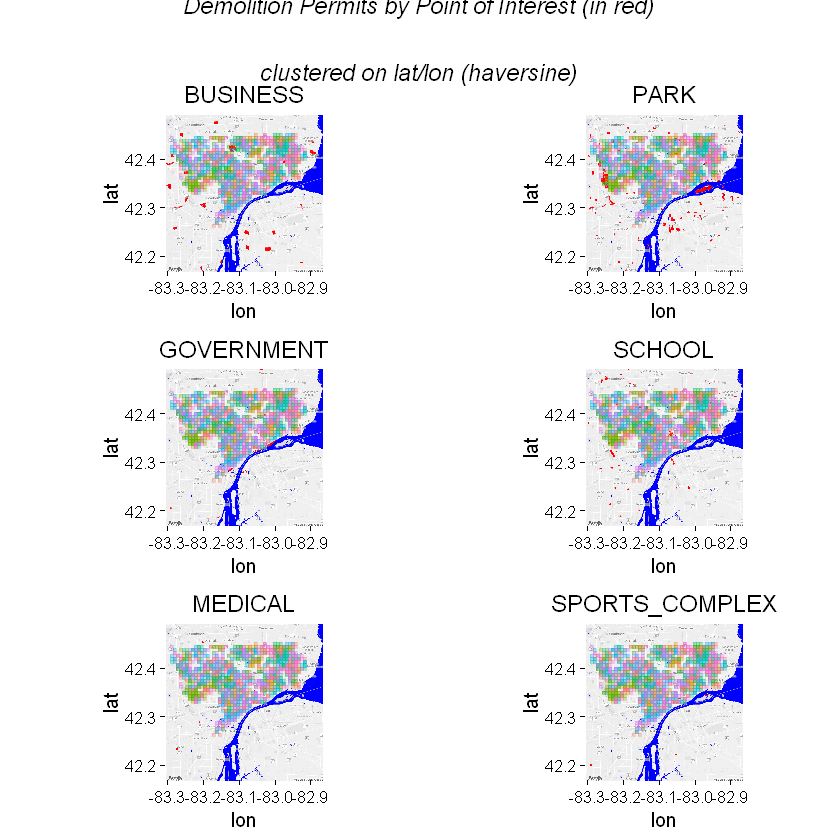

In [23]:
# Compute radius of Earth to Detroit latitude for Haversine : 
# radiusdetroit = sqrt( (  (6378137^2 * cos(42.331429))^2 + (6356752^2 * sin(42.331429))^2 ) /
#                           ( (6378137 * cos(42.331429))^2 + (6356752 * sin(42.331429))^2 ) )
#
detdem   <- readRDS("detdem_geocoded_date.rds")
detdem_modelcl  <- leaderCluster(data.frame(lat=detdem$lat, lon=detdem$lon), radius = .3, distance = "haversine")
detdem$cluster_id <- detdem_modelcl[[1]]
#str(detdem_modelcl)
lc_centroids <- as.data.frame(detdem_modelcl$cluster_centroids)
lc_centroids$cluster_id <- seq(1:nrow(detdem_modelcl$cluster_centroids))
names(lc_centroids) <- c("lat", "lon", "cluster_id")
# str(lc_centroids)

poi <- c("business", "government", "medical", "park", "school", "sports_complex")
savemappoi(poi, detdem)



#### [High Definition MAP for te above plots](https://github.com/Gianfranco-Campana/datasci_course_materials-1/blob/master/capstone/blight/data/demolition_by_poi_haversine_latlon.pdf)

####  _2. CREATE AND PLOTTING SpatialPolygonsDataFrame_ 

[1] 5712

Note: no visible global function definition for 'c' 


[1] 614

Map from URL : http://maps.googleapis.com/maps/api/staticmap?center=42.330358,+-83.086847&zoom=11&size=640x640&scale=2&maptype=terrain&style=saturation:-100%7Clightness:40&style=feature:water%7Ccolor:0x0000ff&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=42.330358,%20-83.086847&sensor=false
Map from URL : http://maps.googleapis.com/maps/api/staticmap?center=42.330358,+-83.086847&zoom=11&size=640x640&scale=2&maptype=terrain&style=saturation:-100%7Clightness:40&style=feature:water%7Ccolor:0x0000ff&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=42.330358,%20-83.086847&sensor=false


pdf 
  2

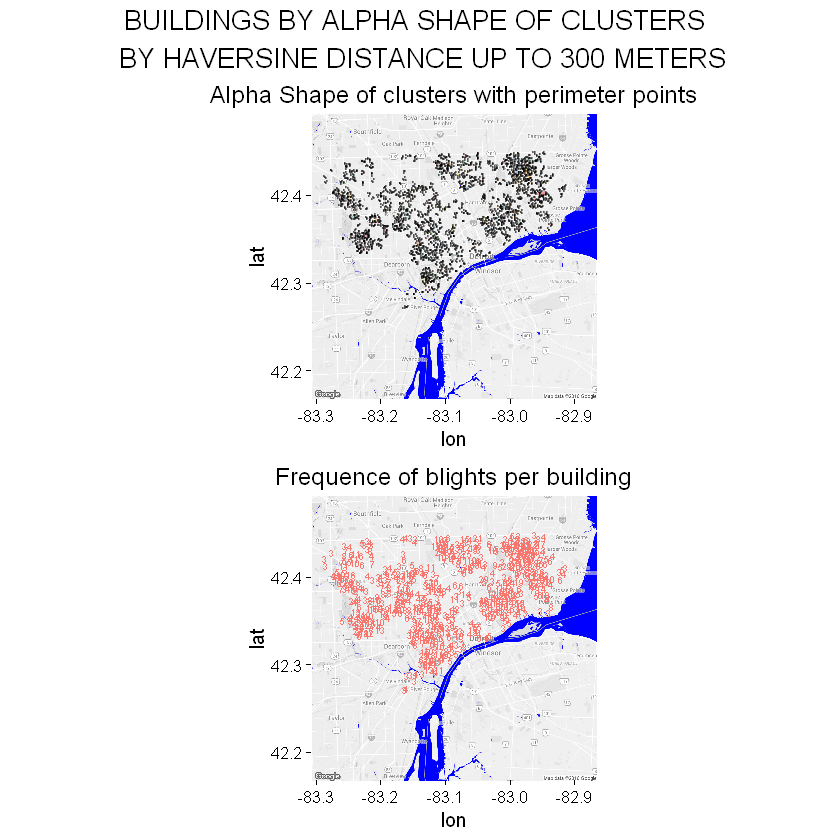

In [24]:
# Create list of ahull of type alpha shape for each cluster
# Each data frame of the list, contains the polygon coordinates of the alpha shape for that cluster

# Script to plot an alpha shape on ggplot2 from a given sets of points
# Inspired by: https://rpubs.com/geospacedman/alphasimple

# Normalize lat lon
detdem$lat <- round(detdem$lat, 11)
detdem$lon <- round(detdem$lon, 11)

# Remove duplicated points - only for creating hull purpoise
detdem$latlon <- paste(as.character(detdem$lat), as.character(detdem$lon))
detdem_nodup <- detdem[-c(which(duplicated(detdem$latlon))), ]

# remove cluster  with less then 3 points - ONLY FOR CREATING HULL PURPOISE
ft <- data.frame(table(detdem_nodup$cluster_id))
ft <- ft[which(ft$Freq > 2 ),]$Var1
#ft
# detdem_nodup <- detdem_nodup[which(detdem_nodup$cluster_id %in% ft),]
nrow(detdem_nodup)

# Compute centroids without outliers
ashape_centroids <- lc_centroids[which(lc_centroids$cluster_id %in% ft),]
ash <- list()
ahu <- list()
for (c in ft) {
    #print(paste("computing cluster n.: ", c))
    # Extract points by cluster.c=101
    # clpoints <-  as.data.frame(remove.duplicates(SpatialPoints((data.frame(lat=detdem[(which(detdem$cluster_id ==  c)),]$lat,    
    # lon=detdem[(which(detdem$cluster_id == c)),]$lon)))))
    clpoints <-  data.frame(lat=detdem_nodup[(which(detdem_nodup$cluster_id ==  c)),]$lat, 
                            lon=detdem_nodup[(which(detdem_nodup$cluster_id == c)),]$lon)        
    
    # Computation And Order Alpha Shape 
    cl_ahull = ahull(clpoints, alpha = 2)
    cl_ashape = cl_ahull$ashape.obj
    # Take the coordinates of points on the edges of the alpha shape (as.character to not lost the order!)
    cl_mat = cl_ashape$edges[, c("ind1", "ind2")]
    # Convert 'numeric' matrix to 'character' matrix, to avoid wrong node orders 
    # (Otherwise 'graph.edgelist()' interprets number as order of nodes)
    class(cl_mat) = "character"
    # Make the graph of points
    cl_graph = graph.edgelist(cl_mat, directed = F)
    # Cut open the graph to walk through it in order
    cut_graph = cl_graph - E(cl_graph)[1]  # Cut the first edge
    ends = names(which(degree(cut_graph) == 1))   # Get two nodes with degree = 1        
    # Compute a path
    path = get.shortest.paths(cut_graph, ends[1], ends[2])$vpath[[1]]
    # Get node names (= row numbers in original data.frame)
    path_nodes = as.numeric(V(cl_graph)[path]$name)
    # Compute a path
    ash[[paste0("ash",c)]] <- clpoints[path_nodes, ]
    ahu[[paste0("ahu",c)]] <- cl_ahull
    # print so:   +  geom_polygon(data = ex[path_nodes, ], fill = "purple", alpha = 0.5)
}

# 614 ahull freq > 2.
# All derived from detdem.
length(ash) 

cluster_freq <- data.frame()
for (c in ft) {
    clpoints <-  data.frame(lat=detdem_nodup[(which(detdem_nodup$cluster_id ==  c)),]$lat, 
                            lon=detdem_nodup[(which(detdem_nodup$cluster_id == c)),]$lon)        
    freq <- nrow(clpoints)
    freq_clpoints <- cbind(clpoints, freq)[1,]
    cluster_freq <- rbind(cluster_freq, freq_clpoints)
}
#cluster_freq

savemapashape(ash)

# coords = c(42.39, -83.70  )
# b = "ahu1"
# plot(ahu[["ahu1"]])
# getbuildings(c(42.43000232323, -82.97000233323  ), ahu)
# getbuildings(c(42.445890285, -82.987933397), ahu)
# getbuildings(c(42.441023443, -83.0234533345  ), ahu)
# getbuildings(c(42.39, -82.96  ), ahu)

#### [High Definition MAP for te above plots](https://github.com/Gianfranco-Campana/datasci_course_materials-1/blob/master/capstone/blight/data/Buildings%20by%20Alpha%20Shape%20of%20clusters%20300m.pdf)

#### _3. Assign one or more cluster to each point of other datasets :  cluster id if found,  cluster 0 if not found_

In [ ]:
if (runThis == T) {
#################################################################
# detdem already has the cluster_id column, but it is the       #
# original, numeric one, inlcuding cluster with less then three #
# locations. Normalize detdem cluster_id with the same          #
# classification as the others datasets.                        # 
#                                                               #
#################################################################
detdem  <- readRDS("detdem_geocoded_date.rds")
res <- apply(data.frame(detdem$lat, detdem$lon), 1, assign_buildings, ahu)
detdem$cluster_id <- res
# Check locations with multiple cluster.
# detdem[which(round(detdem$lat, 2) == 42.39 & round(detdem$lon, 2) == -82.96),][1:10,]

# detviol
detviol  <- readRDS("detviol_geocoded_date.rds")
res <- apply(data.frame(detviol$lat, detviol$lon), 1, assign_buildings, ahu)
detviol$cluster_id <- res
# Check locations with multiple cluster.
# detviol[which(round(detviol$lat, 2) == 42.39 & round(detviol$lon, 2) == -82.96),][1:10,]

# detcrime
detcrime  <- readRDS("detcrime_geocoded_date.rds")
res <- apply(data.frame(detcrime$lat, detcrime$lon), 1, assign_buildings, ahu)
detcrime$cluster_id <- res
# Check locations with multiple cluster.
# detcrime[which(round(detcrime$lat, 2) == 42.39 & round(detcrime$lon, 2) == -82.96),][1:10,]

# det311
det311  <- readRDS("det311_geocoded_date.rds")
res <- apply(data.frame(det311$lat, det311$lon), 1, assign_buildings, ahu)
det311$cluster_id <- res
# Check locations with multiple cluster.
# det311[which(round(det311$lat, 2) == 42.39 & round(det311$lon, 2) == -82.96),][1:10,]

#str(det311)

saveRDS(detdem,   "detdem_geocoded_clustered_3_date.rds")
saveRDS(detviol,  "detviol_geocoded_clustered_3_date.rds")
saveRDS(detcrime, "detcrime_geocoded_clustered_3_date.rds")
saveRDS(det311,   "det311_geocoded_clustered_3_date.rds")


}

### Add cluster weigth (how many times a cluster appears in the dataset).

In [ ]:
detdem    <- readRDS("detdem_geocoded_clustered_3_date.rds")
detviol   <- readRDS("detviol_geocoded_clustered_3_date.rds")
detcrime  <- readRDS("detcrime_geocoded_clustered_3_date.rds")
det311    <- readRDS("det311_geocoded_clustered_3_date.rds")
# detviol
freq <- as.data.frame(table(detviol$cluster_id))
detviol <- merge(detviol, freq, by.x = "cluster_id", by.y = "Var1", all.x = T)
# Reorder
detviol <- detviol[,c(2:ncol(detviol), 1)]
str(detviol)

# detcrime
freq <- as.data.frame(table(detcrime$cluster_id))
detcrime <- merge(detcrime, freq, by.x = "cluster_id", by.y = "Var1", all.x = T)
# Reorder
detcrime <- detcrime[,c(2:ncol(detcrime), 1)]
str(detcrime)

# det311
freq <- as.data.frame(table(det311$cluster_id))
det311 <- merge(det311, freq, by.x = "cluster_id", by.y = "Var1", all.x = T)
# Reorder
det311 <- det311[,c(2:ncol(det311), 1)]
str(det311)

# detdem
freq <- as.data.frame(table(detdem$cluster_id))
detdem <- merge(detdem, freq, by.x = "cluster_id", by.y = "Var1", all.x = T)
# Reorder
detdem <- detdem[,c(2:ncol(detdem), 1)]
str(detdem)

colnames(detviol) <- tolower(colnames(detviol))
colnames(detcrime) <- tolower(colnames(detcrime))
colnames(det311) <- tolower(colnames(det311))
colnames(detdem) <- tolower(colnames(detdem))

saveRDS(detdem,  "detdem_geocoded_clustered_3_date_nbuild_f_recomputed_300m.rds")
saveRDS(detviol,  "detviol_geocoded_clustered_3_date_nbuild_f_recomputed_300m.rds")
saveRDS(detcrime, "detcrime_geocoded_clustered_3_date_nbuild_f_recomputed_300m.rds")
saveRDS(det311,   "det311_geocoded_clustered_3_date_nbuild_f_recomputed_300m.rds")


### Remove duplicate lat lon for unique buildings: 
#### NOTE : Now, we have the frequence for each cluster, that inludes how many locations are in that cluster.  Therefore, we can identify the unique buildings by unique lat lon, without loss the frequency  info.


### ENGENEERING NEW FEATURES    
##### 1. average judgmentamt per building
##### 2. number of incidents (311 calls) per cluster
##### 3. number of incidents (crime) per cluster
##### 4. number of incidents (violation) per cluster

In [26]:
detdem   <- readRDS("detdem_geocoded_clustered_3_date_nbuild_f_recomputed_300m_nodup.rds")
detviol  <- readRDS("detviol_geocoded_clustered_3_date_nbuild_f_recomputed_300m_nodup.rds")
detcrime <- readRDS("detcrime_geocoded_clustered_3_date_nbuild_f_recomputed_300m_nodup.rds")
det311   <- readRDS("det311_geocoded_clustered_3_date_nbuild_f_recomputed_300m_nodup.rds")
#####################################################################
#                                                                   # 
# train a model using :                                             #
#                                                                   #
#          1. freq (number of bligthed location per building)       #
#          2. Average judgmentamt  per building                     #
#          3. Number of 311 calls  per building                     #
#          4. Number of crimes     per building                     #
#          5. Number of violations per building                     #
#                                                                   # 
#####################################################################
# Here, the number of events for location outside any "building" (cluster of blighted location),
# only count for itself. The freq has to be valued accordingly.

allevents[which(allevents$cluster_id == 0 & allevents$type == "det311"),]$count_311   <- 1
allevents[which(allevents$cluster_id == 0 & allevents$type == "detcrime"),]$count_crime <- 1
allevents[which(allevents$cluster_id == 0 & allevents$type == "detviol"),]$count_viol  <- 1

allevents[which(allevents$cluster_id == 0 & allevents$type != "detdem"),]$freq  <- 0

allevents$label <- ""
allevents[which(allevents$cluster_id != 0 | allevents$type == "detdem"),]$label <- "blight"
allevents[which(allevents$cluster_id == 0 & allevents$type != "detdem"),]$label <- "not_blight"

# CreateDataPartition preserves the proportion of the outcome variables.
# We bootstrap a sample for the negative outcome the same as the positive 
# to follow the guidelines.

# Sample return a vector of indices
sam <- allevents[which(allevents$label == "not_blight"),][sample(nrow(allevents[which(allevents$label == "blight"),]), 
                                                                 nrow(allevents[which(allevents$label == "blight"),])),]
#nrow(sam)

sampled_events <- rbind(
    allevents[which(allevents$label == "blight"),],
    sam
) 

trainIndex <- createDataPartition(sampled_events$label, p = .5,
                                  list = FALSE,
                                  times = 1)

eventstrain <- sampled_events[trainIndex,]
eventstest  <- sampled_events[-trainIndex,]

## 5-fold Cross Validation
fitControl <- trainControl(
    method =  "repeatedcv",
    number = 5,
    repeats = 5)

# Including freq will lead to a perfect model.
eventstrain$label <- factor(eventstrain$label)
glmfit1 <- train(label ~ 
                      freq,
                     # + avg_judg
                     # + count_viol
                     # + count_crime
                     # + count_viol,
                 data = eventstrain,
                 method = "bayesglm",
                 trControl = fitControl,
                 family = "quasibinomial")
)
glmfit1  

Note: no visible global function definition for 'c' 


Bayesian Generalized Linear Model 

8968 samples
   9 predictor
   2 classes: 'blight', 'not_blight' 

No pre-processing
Resampling: Cross-Validated (5 fold, repeated 5 times) 
Summary of sample sizes: 7174, 7175, 7174, 7175, 7174, 7175, ... 
Resampling results

  Accuracy       Kappa         Accuracy SD      Kappa SD      
  0.82970545456  0.6594098143  0.0086847246434  0.017380888992

 

### Predicting on test set       

In [27]:
eventstest1 <- eventstest
eventstest1$label <- NULL

predglm <- predict(glmfit1, newdata=eventstest1)
confusionMatrix(predglm, eventstest$label)



Confusion Matrix and Statistics

            Reference
Prediction   blight not_blight
  blight       3026          0
  not_blight   1457       4483
                                                 
               Accuracy : 0.83749721             
                 95% CI : (0.82969596, 0.8450785)
    No Information Rate : 0.5                    
    P-Value [Acc > NIR] : < 2.22045e-16          
                                                 
                  Kappa : 0.67499442             
 Mcnemar's Test P-Value : < 2.22045e-16          
                                                 
            Sensitivity : 0.67499442             
            Specificity : 1.00000000             
         Pos Pred Value : 1.00000000             
         Neg Pred Value : 0.75471380             
             Prevalence : 0.50000000             
         Detection Rate : 0.33749721             
   Detection Prevalence : 0.33749721             
      Balanced Accuracy : 0.83749721             
  